# Modelado de Topicos en Especificaciones de API's REST con LDA usando NLTK y Gensim

Este trabajo se propone identificar topicos presentes en la descripcion de las API's REST disponibles en el repositorio https://github.com/APIs-guru/openapi-directory/tree/master/APIs con el objetivo de detectar información referida a prácticas de despligue y aspectos no funcionales de una apliacación. En particular, el enfoque se basa en el modelado de tópicos utilizando el modelo Latent Dirichlet Allocation (LDA), un modelo probabilístico generativo de tópicos. 

El repositorio analizado está formado por 326 aplicaciones (adobe, instagram, amazon, github, entre otras) que contienen 1418 archivos "swagger.yaml" y "openapi.yaml" y, de estos últimos, 1026 (72,35\%) contienen las propiedades "description" y "summary" que fueron usadas para formar los documentos.

El flujo de trabajo propuesto para la detección de los tópicos consta de cuatro etapas: I) Generación del corpus, II) Pre-procesamiento, III) Construcción del modelo, y IV) Identificación de tópicos. La implementación se llevó a cabo con los paquetes NLTK y SKLearn de Python.

**I)- Generación del Corpus:** El primer paso fue crear el corpus de referencia a partir de las especificaciones de APIs del repositorio en estudio. El proceso consistió en recorrer el repositorio y, para cada uno de los archivos swagger y openapi que se encuentran en los distintos directorios de las aplicaciones, generar un documento con la información presente en los tags "description" y "summary" (para cada operación http del path correspondiente). Finalmente, se obtuvo un corpus con un total de 1026 documentos.

In [1]:
import sys
import os
import yaml

data_list=[]

for base, dirs, files in os.walk('D:/ISISTAN/Cursos/Mineria de datos/Trabajo topicos/openapi-directory-master/APIs-original'):
    for f in files:
        text_document = ''
        if f == "swagger.yaml" or f == "openapi.yaml":
            data = yaml.safe_load(open(os.path.join(base,f), encoding="utf8"))
            try:
                if 'description' in list(data['info'].keys()):
                    text_document = str(data['info']['description']) + ' '
                    #data_list.append(data['info']['description'])
                    #print(data['info']['description'])
                    
                for api in data['paths'].keys():
                    for methodHTTP in data['paths'][api].keys():
                        #print(data['paths'][api][methodHTTP].keys())
                        if 'summary' in list(data['paths'][api][methodHTTP].keys()):
                            text_document = text_document + str(data['paths'][api][methodHTTP]['summary']) + ' '
                            #print(data['paths'][api][methodHTTP]['summary'])
                            #data_list.append(data['paths'][api][methodHTTP]['summary'])
               
                text_document = text_document[0:len(text_document)-1] #quita el ultimo espacio agregado al final d la cadena
                data_list.append(text_document)
            except (OSError, RuntimeError, TypeError, NameError, AttributeError):
                    pass
    
                
print ('NUMERO DE ELEMENTOS: ' + str(len(data_list)))
print(data_list[:2])

NUMERO DE ELEMENTOS: 1026
['Stock and Forex Data and Realtime Quotes Get quotes for all symbols Get a list of symbols for which we provide real-time quotes', 'Strong authentication, without the passwords.']


**II) Pre-procesamiento:** Para la etapa de pre-procesamiento se realizaron 4 actividades, a saber:

* Tokenización: se generaron los tokens usando el método simple_preprocess() que nos brinda Gensim.

In [3]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel

#TOKENIZACION CON GENSIM
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data_list))
print(data_words[:1])

[['stock', 'and', 'forex', 'data', 'and', 'realtime', 'quotes', 'get', 'quotes', 'for', 'all', 'symbols', 'get', 'list', 'of', 'symbols', 'for', 'which', 'we', 'provide', 'real', 'time', 'quotes']]


* Filtro de stopwords: se llevó a cabo empleando la misma lista de stopwords definida para el experimiento en SKLearn.

In [4]:
import numpy as np
import re, nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import ascii_lowercase

#ELIMINACION DE STOPWORDS
stop_words = stopwords.words('english')
stop_words.extend(['WWW','www','HTTP', 'http', 'HTTPS', 'https', 'api', 'API','apis', 'APIS', 'REST', 'rest','RESTfull',
                  'RESTful', 'restfull', 'restful', 'service', 'services', 'user', 'users','get','post','put','delete',
                  'request', 'response', 'url', 'URL', 'curl','token', 'json', 'crud', 'create', 'update', 'data',
                  'code', 'list', 'tokens', 'urls','html', 'html5','yaml', 'httpclient','httprequest','httpresponse'
                  'client','clients', 'lenguaje']
                  + list(ascii_lowercase))

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Remove Stop Words
wordsFiltered = remove_stopwords(data_words)
print(wordsFiltered[:2])

[['stock', 'forex', 'realtime', 'quotes', 'quotes', 'symbols', 'symbols', 'provide', 'real', 'time', 'quotes'], ['strong', 'authentication', 'without', 'passwords']]


* Lematizacion: para la lematización se usó la biblioteca _Spacy_, seleccionando solamente las palabras que eran sustantivos, adjetivos, verbos y adverbios mediante pos-tagging, proceso que asigna (o etiqueta) a cada una de las palabras de un texto su categoría gramatical.

In [6]:
#conda install -c conda-forge spacy
#python -m spacy download en (INSTALAR DESDE LA CONSOLA DE ANACONDA COMO ADMIN)

import spacy
nlp = spacy.load('en') # load model with shortcut link "en"

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(wordsFiltered, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

[['stock', 'forex', 'realtime', 'quote', 'quote', 'symbol', 'symbol', 'provide', 'real', 'time', 'quote'], ['strong', 'authentication', 'password']]


* Vectorización: Gensim crea una identificación única para cada palabra en el documento. El corpus (o matriz de términos) producido es un mapeo de (palabra_id, palabra_frequencia). Por ejemplo, (0, 1) implica que la palabra id 0 aparece una vez en el documento. Esto se usa como entrada para el modelo LDA.

In [7]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:3])

[[(0, 1), (1, 1), (2, 3), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1)], [(8, 1), (9, 1), (10, 1)], [(1, 1), (8, 3), (9, 2), (11, 4), (12, 1), (13, 4), (14, 23), (15, 2), (16, 1), (17, 1), (18, 5), (19, 1), (20, 1), (21, 1), (22, 5), (23, 2), (24, 4), (25, 8), (26, 1), (27, 2), (28, 2), (29, 1), (30, 6), (31, 2), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 6), (39, 1), (40, 5), (41, 16), (42, 1), (43, 1), (44, 2), (45, 2), (46, 6), (47, 1), (48, 1), (49, 1), (50, 1), (51, 15), (52, 7), (53, 2), (54, 1), (55, 1), (56, 2), (57, 1), (58, 2), (59, 1), (60, 1), (61, 3), (62, 7), (63, 1), (64, 1), (65, 24), (66, 1), (67, 1), (68, 1), (69, 31), (70, 4), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 2), (77, 2), (78, 1), (79, 10), (80, 2), (81, 2), (82, 14), (83, 1), (84, 1), (85, 1), (86, 1), (87, 5), (88, 1), (89, 3), (90, 5), (91, 1), (92, 4), (93, 1), (94, 1), (95, 1), (96, 2), (97, 6), (98, 1), (99, 1), (100, 2), (101, 11), (102, 1), (103, 2), (104, 2), (105, 1), (106, 1), (1

**III)- Construcción del modelo:** En Gensim, la construcción del modelo LDA se realiza instanciando la clase _gensim.models.ldamodel_ e invocando al método LdaModel(). Para evitar la tarea manual de prueba y evaluación de los parámetros del modelo, se implementó una función que genera modelos LDA según una lista de parámetros. En este experimento el parámetro evaluado fue num_topics en un rango de valores del 1 al 10. Como se puede observar en la Figura, el valor de la _Función de Verosimilitud_ alcanza su valor máximo (-463593.7929699719) cuando el número de tópicos es 3, mientras que la _perplexity_ del modelo es 124.4575.

Perplexity: -466735.116956234
Per-word Perplexity: 128.59289485344783
Perplexity: -464047.9522293898
Per-word Perplexity: 125.04704687233036
Perplexity: -464541.52488672733
Per-word Perplexity: 125.69092952868195
Perplexity: -463624.4709339142
Per-word Perplexity: 124.49723056392595
Perplexity: -462837.8166472316
Per-word Perplexity: 123.48230590404978
Perplexity: -463059.7997870445
Per-word Perplexity: 123.7678629403807
Perplexity: -464218.88972324133
Per-word Perplexity: 125.26966654415399
Perplexity: -466145.4416618163
Per-word Perplexity: 127.80627544483524
Perplexity: -467808.89278769493
Per-word Perplexity: 130.03775418937755
Perplexity: -472120.24627941847
Per-word Perplexity: 136.0043644716064


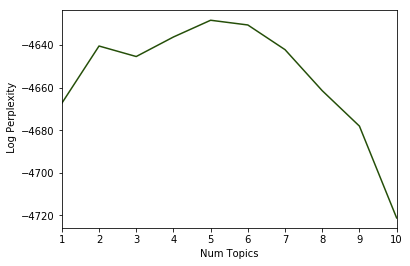

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
grid = defaultdict(list)

# num topics
parameter_list=[1,2,3,4,5,6,7,8,9,10]

# for num_topics_value in num_topics_list:
for parameter_value in parameter_list:
    # run model
    model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=parameter_value)
    perplex = model.bound(corpus)
    print ("Perplexity: %s" % perplex)
    grid[parameter_value].append(perplex/100)
    
    per_word_perplex = np.exp2(-perplex / sum(cnt for document in corpus for _, cnt in document))
    print ("Per-word Perplexity: %s" % per_word_perplex)
    grid[parameter_value].append(per_word_perplex)

df = pd.DataFrame(grid)
df.iloc[0].transpose().plot(color="#254F09")
plt.xlim(parameter_list[0], parameter_list[-1])
plt.ylabel(' Log Perplexity')
plt.xlabel('Num Topics')
plt.title('')
plt.show()

In [36]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# Build LDA model
optimal_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           #random_state=100,
                                           #update_every=1,
                                           #chunksize=100,
                                           passes=100,
                                           alpha='auto')
                                           #per_word_topics=True)

**IV)- Identificación de Tópicos:** La clase _ldamodel_ de Gensim contiene el método print_topics((num\_words=30)) al cuál al ser invocado muestra las 30 primeras palabras de los tópicos de nuestro modelo LDA. La salida luego de la invocación se muestra a continuación:

In [37]:
from pprint import pprint
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))

[(0,
  '0.045*"get" + 0.030*"fabric" + 0.019*"specify" + 0.019*"cluster" + '
  '0.018*"player" + 0.015*"use" + 0.013*"certificate" + 0.012*"application" + '
  '0.012*"key" + 0.012*"stat" + 0.011*"health" + 0.011*"information" + '
  '0.011*"delete" + 0.009*"echo" + 0.009*"create" + 0.009*"br" + 0.009*"team" '
  '+ 0.009*"node" + 0.008*"game" + 0.007*"vault" + 0.007*"detail" + '
  '0.007*"container" + 0.007*"endpoint" + 0.007*"season" + 0.007*"update" + '
  '0.007*"operation" + 0.007*"resource" + 0.006*"date" + 0.006*"recovery" + '
  '0.006*"facility"'),
 (1,
  '0.020*"specify" + 0.015*"search" + 0.012*"use" + 0.012*"would" + '
  '0.010*"job" + 0.010*"com" + 0.009*"specific" + 0.009*"li" + 0.009*"account" '
  '+ 0.008*"find" + 0.008*"return" + 0.008*"type" + 0.007*"task" + '
  '0.006*"give" + 0.006*"page" + 0.006*"image" + 0.006*"list" + 0.006*"add" + '
  '0.006*"information" + 0.006*"collection" + 0.006*"object" + 0.006*"node" + '
  '0.006*"span" + 0.006*"compute" + 0.006*"get" + 0.006*

**Visualizacion de Topicos Dominantes por Documento:** Para clasificar un documento como perteneciente a un tópico en particular, el enfoque usado es ver qué tópico tiene la mayor contribución a ese documento y asignarlo. En la siguiente tabla se listan los primeros 10 documentos junto con la proporción de contribución a cada tópico. El tópico predominante se detalla aparte en su propia columna.

In [38]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,2), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.98,"return, get, give, fetch, resource, com, hub, ...",Stock and Forex Data and Realtime Quotes Get q...
1,1,1.0,0.93,"specify, search, use, would, job, com, specifi...","Strong authentication, without the passwords."
2,2,3.0,0.85,"return, get, give, fetch, resource, com, hub, ...",### The Internet of Things for Everyone\n\nThe...
3,3,2.0,0.53,"azure, network, microsoft, management, web, en...",Swagger AEM is an OpenAPI specification for Ad...
4,4,3.0,0.99,"return, get, give, fetch, resource, com, hub, ...",A web service to initiate and authorise paymen...
5,5,3.0,0.99,"return, get, give, fetch, resource, com, hub, ...",A web service to initiate and authorise paymen...
6,6,3.0,0.99,"return, get, give, fetch, resource, com, hub, ...",A web service to initiate and authorise paymen...
7,7,3.0,0.62,"return, get, give, fetch, resource, com, hub, ...",A set of API endpoints that allow you to initi...
8,8,3.0,0.58,"return, get, give, fetch, resource, com, hub, ...",A set of API endpoints that allow you to initi...
9,9,4.0,0.71,"project, retrieve, order, new, group, product,...",Additional methods that allow you to manage pa...


**Número de documentos por tópico:** Finalmente, haciendo una distribución cruzada de los datos se obtiene el número de documentos en los que aparece un determinado topico.

In [42]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 1)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics[:5]

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,3.0,"return, get, give, fetch, resource, com, hub, ...",103.0,0.1
1,1.0,"specify, search, use, would, job, com, specifi...",174.0,0.2
2,3.0,"return, get, give, fetch, resource, com, hub, ...",512.0,0.5
3,2.0,"azure, network, microsoft, management, web, en...",117.0,0.1
4,3.0,"return, get, give, fetch, resource, com, hub, ...",120.0,0.1


**Visualización del Tópico dominante:** Una forma de visualización muy común son las _Word Clouds_ (nube de palabras). Es una imagen compuesta por una combinación de palabras distintas que pueden constituir un texto y donde el tamaño de cada palabra es proporcional a la frecuencia de la palabra en ese texto. A continuación, se generan las word clouds para los tópicos obtenidos.

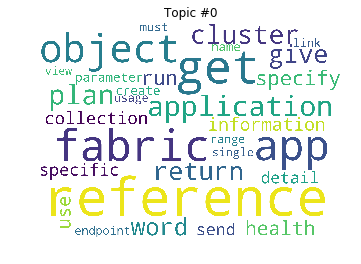

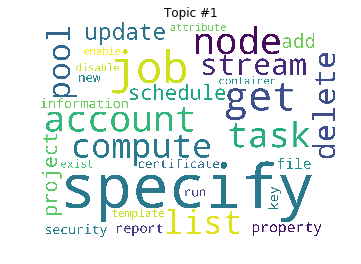

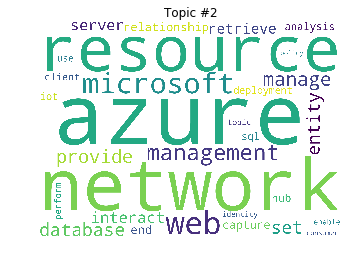

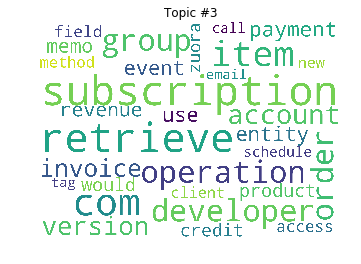

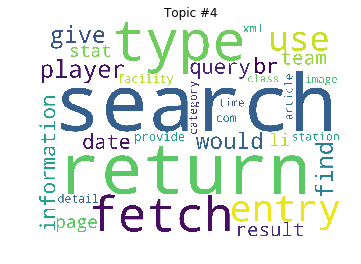

In [40]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud( background_color='white',
                          width=2500,
                          height=1800).fit_words(dict(lda_model.show_topic(t, 30))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()